# **Mask R-CNN Instance Based Image Segmentation**

**Code:** Mask R-CNN for object detection and instance segmentation on Keras and TensorFlow, Waleed Abdulla, 2017, https://github.com/matterport/Mask_RCNN

**Paper:** K. He, G. Gkioxari, P. Dollár and R. Girshick, "Mask R-CNN," 2017 IEEE International Conference on Computer Vision (ICCV), Venice, 2017, pp. 2980-2988, doi: 10.1109/ICCV.2017.322.


# **I. Install Dependencies and Import Libraries**

In [16]:
%pwd

'/Users/Alpaca/Desktop/研究/Super-Resolution-Nuclei-Segmentation-main'

## I.a. Install Required Packages

In [3]:
import os


GPU = True 
!pip install scikit-image
!pip install keras==2.2.5
!pip uninstall -y tensorflow
if GPU == True:
    !pip install tensorflow-gpu==1.14
else:
    !pip install tensorflow==1.14 


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement tensorflow-gpu==1.14 (from versions: none)
ERROR: No matching distribution found for tensorflow-gpu==1.14


## I.b. Download and Install Mask R-CNN

In [ ]:
# Download Mask R-CNN
if not os.path.exists('./root/Mask_RCNN'):
    %cd ./root/
    !git clone --quiet https://github.com/matterport/Mask_RCNN.git
    %cd ./Mask_RCNN
else:
    %cd ./root/Mask_RCNN

# Install Mask R-CNN
!pip install -q PyDrive
!python setup.py install
!pip install colorspacious
!git clone --quiet https://github.com/taketwo/glasbey.git
!pip install imagecodecs
!pip install h5py==2.10.0

%pwd

## I.c. Import Libraries and Mount Drive

In [8]:
import cv2
from tqdm import tqdm
import shutil
import numpy as np
import matplotlib.pyplot as plt
import skimage
from skimage.measure import label, regionprops
import tensorflow
import keras
from mrcnn.config import Config
from mrcnn import utils
from mrcnn import model as modellib
from mrcnn import visualize
from datetime import timedelta
import datetime
import imageio
import math
import pytz
from pytz import timezone
from imgaug import augmenters as iaa
import imagecodecs._imcd
from tifffile import imread

In [ ]:
%cd ../..

# **II. Setup Data Paths, Load and Process Images**

In [9]:
%pwd

'/Users/Alpaca/Desktop/研究/Super-Resolution-Nuclei-Segmentation-main'

## II.a. Set data path

In [4]:
import os

DATA_PATH = "./root/datasets"

TEST_PATH = "./root/datasets/test" 
TEST_LABEL_PATH = "./root/datasets/testlabel"

if not os.path.exists(TEST_PATH):
    os.makedirs(TEST_PATH)
if not os.path.exists(TEST_LABEL_PATH):
    os.makedirs(TEST_LABEL_PATH)
if not os.path.exists(DATA_PATH):
    os.makedirs(DATA_PATH)
    
NOISE_IMG_PATH = "./root/datasets/test"

IMG_SAVE_PATH = "./root/datasets/imagesDN"
NOISE_MAP = "./root/datasets/Noise/map" 

if not os.path.exists(IMG_SAVE_PATH):
    os.makedirs(IMG_SAVE_PATH)
if not os.path.exists(NOISE_MAP):
    os.makedirs(NOISE_MAP)

## II.b. Resize Your Images

In [5]:
M = 512 
N = 512

def bin_ndarray(ndarray, new_shape, operation='sum'):

    operation = operation.lower()
    if not operation in ['sum', 'mean']:
        raise ValueError("Operation not supported.")
    if ndarray.ndim != len(new_shape):
        raise ValueError("Shape mismatch: {} -> {}".format(ndarray.shape,
                                                           new_shape))
    compression_pairs = [(d, c//d) for d,c in zip(new_shape,
                                                  ndarray.shape)]
    flattened = [l for p in compression_pairs for l in p]
    ndarray = ndarray.reshape(flattened)
    for i in range(len(new_shape)):
        op = getattr(ndarray, operation)
        ndarray = op(-1*(i+1))
    return ndarray

def image_normalized(file_path):
    img = cv2.imread(file_path,0)
    new_shape=[M,N]
    top_size,bottom_size,left_size,right_size=0,0,0,0
    if len(img.shape) == 2:
        d,c = new_shape[0],img.shape[0]
        dd,cc = new_shape[1],img.shape[1]
        if c//d != c/d or cc//dd != cc/dd:
            if c//d != c/d:
                top_size,bottom_size = int(((c//d+1)*d-c)/2),int(((c//d+1)*d-c)/2)
            if cc//dd != cc/dd:
                left_size,right_size=int(((cc//dd+1)*d-cc)/2),int(((cc//dd+1)*dd-cc)/2)
            print("top_size,bottom_size,left_size,right_size is ",top_size,bottom_size,left_size,right_size)
            img=cv2.copyMakeBorder(img,top_size,bottom_size,left_size,right_size,cv2.BORDER_CONSTANT,value=(0,0,0))
    img_shape = img.shape
    print(img_shape)
    image_size = (img_shape[1],img_shape[0])
    img_standard = bin_ndarray(img*1.2, (M,N), operation='mean')
    img_new = img_standard
    imgT = img_standard
    img_new = np.asarray([img_new / 255.])
    return img_new,image_size, imgT

/Users/Alpaca/Desktop/研究/Super-Resolution-Nuclei-Segmentation-main/root/unet
/Users/Alpaca/Desktop/研究/Super-Resolution-Nuclei-Segmentation-main


## II.c. Noise Detection and Removal

In [ ]:
# Would you like to conduct noise detection and removal?
NR = True

In [ ]:
# Select Noise Weights and load pre-trained
NOISE_WEIGHTS = "Cell"

if NOISE_WEIGHTS == "Tissue":
    NW = './weights/unet_noise_tissue.hdf5'
elif NOISE_WEIGHTS == "Cell":
    NW = './weights/unet_noise_cell_line.hdf5'
    

    
if NR == True:
    if not os.path.exists('./root/unet'):
        %cd ./root/
        !git clone --quiet https://github.com/zhixuhao/unet.git
        %cd ./unet/
    else:
        %cd ./root/unet/
    from model import *
    from data import *
    import numpy as np 
    import cv2
    import os
    import glob
    import skimage.io as io
    import skimage.transform as trans
    %cd ../..
    model = load_model(NW)
    test_path = NOISE_IMG_PATH
    save_path = NOISE_MAP
    save_path2 = IMG_SAVE_PATH
    container = np.zeros((M,N,1,1));
    
    for name in os.listdir(test_path):
        image_path = os.path.join(test_path,name)
        if os.path.isdir(image_path):
            continue
        ll = len(name)
        print(name)
        img,img_size, imgT = image_normalized(image_path)
        img = np.reshape(img,img.shape+(1,))
        results = model.predict(img)
        out = np.zeros(img.shape)

        out = 255*results[0,:,:,0];

        cv2.imwrite(os.path.join(save_path, ("%s") % (name[0:ll-3]+'png')), out)

        imgDN = imgT - out

        cv2.imwrite(os.path.join(save_path2, ("%s") % (name[0:ll-3]+'png')), imgDN)

%pwd

## II.d. Process Data

In [ ]:
# Run this cell to conduct processing specified above.
def reject_outliers(data, m=2):
    JoeGreen = np.mean(data)
    STD = np.std(data)
    data[(data -JoeGreen) > m*STD] = 0
    return data

MP = 0
Num = 0
fin = 0

Spath = DATA_PATH
if NR == True:
    PATH = IMG_SAVE_PATH
else:
    if Select == "Train":
        PATH = TRAIN_PATH
    elif Select == "Test":
        PATH = TEST_PATH

NME = Select
while fin == 0:
    for name in os.listdir(PATH):

    if Select == "Train":
        path = os.path.join(PATH, name)
        path2 = os.path.join(LABEL_PATH, name)
        if PATH == VAL_PATH:
            path = os.path.join(VAL_PATH, name)
            path2 = os.path.join(VAL_LABEL_PATH, name)
        elif Select == "Test":
            path = os.path.join(PATH, name)
            path2 = os.path.join(TEST_LABEL_PATH, name)

    if os.path.isdir(path):
        continue
    if os.path.isdir(path2):
        continue

    ll = len(name)
    print(name)
    # Get Extension
    if Num == 0:
        nme, ext = os.path.splitext(name)

    if ext == '.tif' or ext == '.tiff':
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      
    else:
        img = cv2.imread(path,0)
    img = img.astype('uint8')

    # Resize
    if Norm == True:
      # Normalize Images
        img = reject_outliers(img, 2)
        img = cv2.equalizeHist(img)
        img = cv2.GaussianBlur(img,(35,35),0)
        img = cv2.normalize(img, None, alpha=0, beta=200, norm_type=cv2.NORM_MINMAX)

    if Resize == True:
        new_shape=[M,N]
        top_size,bottom_size,left_size,right_size=0,0,0,0
      
        if len(img.shape) == 2:
            d,c = new_shape[0],img.shape[0]
            dd,cc = new_shape[1],img.shape[1]
            if c//d != c/d or cc//dd != cc/dd:
                if c//d != c/d:
                    top_size,bottom_size = int(((c//d+1)*d-c)/2),int(((c//d+1)*d-c)/2)
                if cc//dd != cc/dd:
                    left_size,right_size=int(((cc//dd+1)*d-cc)/2),int(((cc//dd+1)*dd-cc)/2)
                print("top_size,bottom_size,left_size,right_size is ",top_size,bottom_size,left_size,right_size)
                img=cv2.copyMakeBorder(img,top_size,bottom_size,left_size,right_size,cv2.BORDER_CONSTANT,value=(0,0,0))
      
        img = bin_ndarray(img*1.2, new_shape=(M,N), operation='mean')
        print("img_shape: ",img.shape)


    sh = img.shape

    # Pixel Average
    if PATH != VAL_PATH:
        if len(sh) == 3 or 4:
            MP = (np.mean(img,axis=(0,1)) + MP)
        else:
            MP = (np.mean(img) + MP)

    Num = Num + 1
    
    if Write == True:
        if not os.path.exists(os.path.join(Spath, NME, name[0:ll-4], "images")):
            os.makedirs(os.path.join(Spath, NME, name[0:ll-4], "images"))
        cv2.imwrite(os.path.join(Spath, NME, name[0:ll-4], "images", name[0:ll-3]+'png'), img)
      
    if Select == "Train" or (Select == "Test" and len(os.listdir(TEST_LABEL_PATH))!=0):
        if ext == '.tif' or ext == '.tiff':
            img2 = imread(path2,0)
        else:
            # img2 = cv2.imread(path2)
            img2 = cv2.cvtColor(path2,cv2.COLOR_BGR2GRAY)
        img2 = label(img2)
        img2 = cv2.resize(img2,(M,N),interpolation=cv2.INTER_NEAREST)
        P = img2.max()
        out = np.zeros([M, N, P])
      
        if Write == True:
        if not os.path.exists(os.path.join(Spath, NME, name[0:ll-4], "masks")):		
            os.mkdir(os.path.join(Spath, NME, name[0:ll-4], "masks"))
        for n in range(1,P+1):
            ind = np.where(img2 == n)
            for i in range(0,ind[0].shape[0]-1):
                out[ind[0][i],ind[1][i],n-1] = 255
            cv2.imwrite(os.path.join(Spath, NME, name[0:ll-4], "masks", name[0:ll-4] + "_" + str(n-1) + ".png"),out[:,:,n-1])

    elif (Select == "Test" and len(os.listdir(TEST_LABEL_PATH))==0):
        img2 = np.ones([M,N])
        out = np.zeros([M, N, 1])

        if Write == True:
            if not os.path.exists(os.path.join(Spath, NME, name[0:ll-4], "masks")):		
            os.mkdir(os.path.join(Spath, NME, name[0:ll-4], "masks"))
        for n in range(1,2):
            ind = np.where(img2 == n)
            for i in range(0,ind[0].shape[0]-1):
                out[ind[0][i],ind[1][i],n-1] = 255
            cv2.imwrite(os.path.join(Spath, NME, name[0:ll-4], "masks", name[0:ll-4] + "_" + str(n-1) + ".png"),out[:,:,n-1])

    if NME == "Train":
        if len(os.listdir(VAL_LABEL_PATH)) != 0:
        PATH = VAL_PATH
        else:
            VTempI = os.path.join(Spath,"VTemp","images")
            VTempM = os.path.join(Spath,"VTemp","masks")
            if not os.path.exists(VTempI):
                os.makedirs(VTempI)
            if not os.path.exists(VTempM):
                os.makedirs(VTempM)
            cv2.imwrite(os.path.join(VTempI,"Val1.png"), np.ones(img.shape))
            cv2.imwrite(os.path.join(VTempM,"Val1.png"), np.ones(img.shape))
            VAL_PATH = VTempI
            VAL_LABEL_PATH = VTempM
            PATH = VAL_PATH
            #PATH = VAL_PATH
        NME = "Val"
    else:
        fin = 1

MP = MP/Num
if len(sh) != 3 or 4:
    MP2 = np.array([MP,MP,MP])
else:
    MP2 = MP

/root
6_555_STED_decon_gamma6.tif
ndarray.shape:  (512, 8, 512, 8)
 
img_shape:  (512, 512)


# III. Configuration

In [ ]:
%cd ./root/Mask_RCNN

class NucleusConfig(Config):
    """Configuration for training on the nucleus segmentation dataset."""
    # Give the configuration a recognizable name
    NAME = "nucleus"
    #@markdown ___
    #@markdown ## **1. Configuration Parameters**
    #@markdown --- Enter Desired Parameters or Leave Defaults

    #@markdown
    # Adjust depending on your GPU memory
    #@markdown ### **A. Batch Size**
    IMAGES_PER_GPU = 1  #@param {type:"integer"}

    #@markdown 
    # Number of classes (including background)
    #@markdown ### **B. Number of Classes**
    #@markdown --- Including Background + Target
    NUM_CLASSES = 2  #@param {type:"integer"}

    #@markdown 
    #@markdown ### **C. Number of Training and Validation Epochs and Steps**
    EPOCHS =  100#@param {type:"integer"}
    STEPS_PER_EPOCH = 100 #@param {type:"integer"}
    VALIDATION_STEPS =  20#@param {type:"integer"}

    # Don't exclude based on confidence. Since we have two classes
    # then 0.5 is the minimum anyway as it picks between nucleus and BG
    #@markdown
    #@markdown ### **D. Confidence Threshold for Target Detection**
    DETECTION_MIN_CONFIDENCE = 0.1 #@param {type:"number"}

    #@markdown
    #@markdown ### **E. Testing Non Maximum Suppression (NMS) Threshold**
    DETECTION_NMS_THRESHOLD = 0.3 #@param {type:"number"}

    # Non-max suppression threshold to filter RPN proposals.
    # You can increase this during training to generate more propsals.
    #@markdown
    #@markdown ### **F. Training RPN NMS Threshold**
    RPN_NMS_THRESHOLD = 0.7 #@param {type:"number"}

    # Backbone network architecture
    # Supported values are: resnet50, resnet101
    #@markdown
    #@markdown ### **G. Network Backbone**
    #@markdown --- Training and Testing Must Use the Same Model
    BACKBONE = "resnet50" #@param ["resnet50", "resnet101"] {type:"string"} 

    # Input image resizing
    # Random crops of size 512x512
    #@markdown
    #@markdown ### **H. Resize Input Images**
    #@markdown --- none: No resizing or padding.
    #@markdown --- crop: Picks random crops from the image.
    #@markdown --- square: Resize and pad with zeros to get a square image of size [max_dim, max_dim].
    #@markdown --- pad64:  Pads width and height with zeros to make them multiples of 64 (test default).
    IMAGE_RESIZE_MODE = "crop" #@param ["none", "crop", "square", "pad64"] {type:"string"}
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 1024
    IMAGE_MIN_SCALE = 2.0

    # Length of square anchor side in pixels
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)

    # ROIs kept after non-maximum supression (training and inference)
    POST_NMS_ROIS_TRAINING = 1000
    POST_NMS_ROIS_INFERENCE = 2000

    # How many anchors per image to use for RPN training
    RPN_TRAIN_ANCHORS_PER_IMAGE = 64

    # Image mean (RGB)
    MEAN_PIXEL = MP2
    #MEAN_PIXEL = np.array([43.53, 39.56, 48.22])

    # If enabled, resizes instance masks to a smaller size to reduce
    # memory load. Recommended when using high-resolution images.
    #@markdown 
    #@markdown ### **I. Mini Masks**
    #@markdown --- Resizes instance masks to a smaller size to reduce memory load. 
    #@markdown --- Recommended when using high-resolution images.
    USE_MINI_MASK = False #@param {type:"boolean"}
    #@markdown Length of mini mask sides
    height = 128 #@param {type:"integer"}
    width = 128 #@param {type:"integer"}
    MINI_MASK_SHAPE = (height, width)  # (height, width) of the mini-mask

    # Number of ROIs per image to feed to classifier/mask heads
    # The Mask RCNN paper uses 512 but often the RPN doesn't generate
    # enough positive proposals to fill this and keep a positive:negative
    # ratio of 1:3. You can increase the number of proposals by adjusting
    # the RPN NMS threshold.
    TRAIN_ROIS_PER_IMAGE = 256

    # Maximum number of ground truth instances to use in one image
    MAX_GT_INSTANCES = 256

    # Max number of final detections per image
    DETECTION_MAX_INSTANCES = 256

    # Learning rate and momentum
    # The Mask RCNN paper uses lr=0.02, but on TensorFlow it causes
    # weights to explode. Likely due to differences in optimizer
    # implementation.
    #@markdown
    #@markdown ### **J. Learning Rate**
    #@markdown Lower values may take longer to acheive a lower loss but larger values may never settle (rec: 0.001-0.00001)
    LEARNING_RATE = 0.0001 #@param {type:"number"}
    LEARNING_MOMENTUM = 0.9

    # Weight decay regularization
    #@markdown Learning rate decay (~1/10 * Learning Rate)
    WEIGHT_DECAY = 0.00001 #@param {type:"number"}

class NucleusInferenceConfig(NucleusConfig):
    # Set batch size to 1 to run one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    # Don't resize imager for inferencing
    IMAGE_RESIZE_MODE = "pad64"
    # Non-max suppression threshold to filter RPN proposals.
    # You can increase this during training to generate more propsals.
    RPN_NMS_THRESHOLD = 0.7

config = NucleusConfig()
config.display()

/root/Mask_RCNN


# IV. Define Functions

## IV.a. Define Classes and Load Images to the Network
* Naming the dataset nucleus, and the class nucleus
* Only 1 class, other than background.  Adjust code and labels to add more.

In [ ]:
class NucleusDataset(utils.Dataset):
    
    def load_nucleus(self, dataset_dir, subset):
        """Load a subset of the nuclei dataset.
        dataset_dir: Root directory of the dataset
        subset: Subset to load. The name of the sub-directory, such as:
                * train: images for training
                * val: validation images
                * test: test images
        """
        # Add classes. We have one class.
        # Naming the dataset nucleus, and the class nucleus
        #@markdown Only 1 class, other than background.  Adjust code and labels to add more.
        DSET_NAMES = "nucleus" #@param {type: "string"}
        CLASS_NAME = "nucleus" #@param {type: "string"}
        self.add_class("nucleus", 1, "nucleus")

        # Which subset?
        # "val": select from data folder val
        # "train": use data from train folder
        # else: use the data from the specified sub-directory
        dataset_dir = os.path.join(dataset_dir, subset)
        image_ids = next(os.walk(dataset_dir))[1]
        print("dataset_dir is ", dataset_dir)
        print("image_ids is ", image_ids)

        # Add images
        for image_id in image_ids:
            self.add_image(
                "nucleus",
                image_id=image_id,
                path=os.path.join(dataset_dir, image_id, "images/{}.png".format(image_id)))

## IV.b. Detection Module

### IV.b.a. Conduct post-processing on predictions?

In [ ]:
PROC = True #@param {type:"boolean"}

In [ ]:
#@markdown Overlap removal (experimental)
utc = pytz.utc
utc_dt = datetime.datetime.now()
eastern = timezone('US/Eastern')
loc_dt = utc_dt.astimezone(eastern)

import colorspacious
from glasbey import Glasbey
from google.colab.patches import cv2_imshow
from skimage.color import label2rgb
import math

color = np.array(([1,0,0],[0,1,0],[0,0,1],[1,1,0],[0,1,1],[1,0,1],[1,0.5,0],[0.5,1,0],[0,1,0.5],[0,0.5,1],[1,0,0.5],[0.5,0,1],[1,0.5,0.25],[0.25,0.5,1],[1,0.25,0.5],[0.5,0.25,1],[0.5,1,0.25],[0.25,1,0.5]),np.float32)
gb = Glasbey(base_palette=color, chroma_range = (60,100), no_black=True)
c4 = gb.generate_palette(size=18)
color4 = c4[1:]

def normalized(rgb):

        norm=np.zeros((512,512,3),np.float32)
        norm_rgb=np.zeros((512,512,3),np.uint8)

        b=rgb[:,:,0]
        g=rgb[:,:,1]
        r=rgb[:,:,2]

        sum=b+g+r

        norm[:,:,0]=b/sum*255.0
        norm[:,:,1]=g/sum*255.0
        norm[:,:,2]=r/sum*255.0

        norm_rgb=cv2.convertScaleAbs(norm)
        return norm_rgb

def overlay(mask, orig, clr):
    maskPR = label(mask)
    labels = label2rgb(label=maskPR, bg_label=0, bg_color=(0, 0, 0), colors=clr)
    L2 = normalized(labels)
    if len(orig.shape) < 3: 
        O2 = cv2.cvtColor(orig.astype('uint8'), cv2.COLOR_GRAY2BGR)
    else:
        O2 = orig
    comb = cv2.addWeighted(L2.astype('float64'),0.5,O2.astype('float64'),0.5,0)
    return comb


Generating color table:   0% |                                 | ETA:   0:01:51

/root/Mask_RCNN


Generating color table: 100% |#################################| Time:  0:01:24
Generating palette: 100% |#####################################| Time:  0:00:04


### IV.b.b. Results Output Folder Name
* submit_dir = 'Tissue_Nucleus'  + '_' +  loc_dt.strftime('%Y-%m-%d_%H:%M:%S_%Z%z')

In [ ]:
def detect(model, dataset_dir, subset):
    """Run detection on images in the given directory."""
    print("Running on {}".format(dataset_dir))

    # Create directory
    if not os.path.exists(RESULTS_DIR):
        os.makedirs(RESULTS_DIR)
        
    # Read dataset
    dataset = NucleusDataset()
    dataset.load_nucleus(dataset_dir, subset)
    dataset.prepare()
    
    ### b. Results Output Folder Name
    #submit_dir = 'Tissue_Nucleus'  + '_' +  loc_dt.strftime('%Y-%m-%d_%H:%M:%S_%Z%z')
    submit_dir = "Denoise_1_488"+loc_dt.strftime('%Y-%m-%d_%H:%M:%S_%Z%z') #@param {type: "raw"} 
    submit_dir = os.path.join(RESULTS_DIR, submit_dir)
    mask_dir = submit_dir + "/masks"
    if not os.path.exists(mask_dir):
        os.makedirs(mask_dir)

    # Load over images
    init = 0
    submission = []
    for image_id in dataset.image_ids:
        # Load image and run detection
        image = dataset.load_image(image_id)
        # Detect objects
        r = model.detect([image], verbose=0)[0]
        # Encode image to RLE. Returns a string of multiple lines
        source_id = dataset.image_info[image_id]["id"]
        rle = mask_to_rle(source_id, r["masks"], r["scores"])
        submission.append(rle)
        # Save image with masks
        visualize.display_instances(
            image, r['rois'], r['masks'], r['class_ids'],
            dataset.class_names, r['scores'],
            show_bbox=True, show_mask=True,
            title="Predictions", captions = None)
        # plt.savefig("{}/{}.png".format(submit_dir, dataset.image_info[image_id]["id"]))

        masks = r['masks'].astype(np.uint8)
        mask = np.zeros([masks.shape[0], masks.shape[1]], dtype='uint8')
        maskD = np.zeros([masks.shape[0], masks.shape[1]], dtype='uint8')
        diff = np.zeros([masks.shape[0], masks.shape[1]], dtype='uint8')
        props = np.zeros((masks.shape[2]))
        for n in range(0,masks.shape[2]):
            if PROC == False:
                mask = mask + (n+1)*masks[:,:,n]
            elif PROC == True:
                M2 = label(masks[:,:,n])
                props2 = regionprops(M2)
                for m in range(0,M2.max()):
                    if props2[m].area < 100:
                        M2[M2==props2[m].label] = 0
                M2[M2 > 0] = 1
                masks[:,:,n] = M2*masks[:,:,n]
                props2 = regionprops(masks[:,:,n])

                maskD = maskD + masks[:,:,n]

                if maskD.max() <= 1:
                    mask = mask + (n+1)*masks[:,:,n]
                else:
                    try:
                        diff[maskD > 1] = 1
                        diff2 = diff.copy()
                        pd = regionprops(diff)

                        area2 = props2[0].area 
                        aread = pd[0].area
                        Vals = diff*mask # Find value of existing region label, under new overlap
                        vals = Vals[Vals>0] # Not zero
                        vals = vals[vals != n+1] # Not the current label
                        vals = list(set(vals)) # Really should only be one left
                        props1 = regionprops(masks[:,:,vals[0]])
                        area1 = props1[0].area
                        div1 = aread/area1
                        div2 = aread/area2
                        dd = vals[0] + n+1

                        mask = mask + (n+1)*masks[:,:,n]
                        if div1 < 0.15 and div2 < 0.15:
                            mask[diff > 0] = vals[0]
                        elif div1 < 0.15 and div2 > 0.15:
                            mask[diff > 0] = n+1
                            mask[mask==vals[0]] = n+1
                        elif div1 > 0.15 and div2 < 0.15:
                            mask[diff > 0] = vals[0]
                            mask[mask==n+1] = vals[0]
                        elif div1 > 0.15 and div2 > 0.15 and div1 < 0.6 and div2 < 0.6:

                            y0, x0 = pd[0].centroid
                            orientation = pd[0].orientation

                            x1 = x0 - math.sin(orientation) * 0.55 * pd[0].major_axis_length
                            y1 = y0 - math.cos(orientation) * 0.55 * pd[0].major_axis_length
                            x2 = x0 + math.sin(orientation) * 0.55 * pd[0].major_axis_length
                            y2 = y0 + math.cos(orientation) * 0.55 * pd[0].major_axis_length 

                            cv2.line(diff, (int(x2),int(y2)), (int(x0),int(y0)), (0, 0, 0), thickness=2)
                            cv2.line(diff, (int(x1),int(y1)), (int(x0),int(y0)), (0, 0, 0), thickness=2)

                            lbl1 = label(diff)
                            lbl1 = lbl1.astype('uint8')
                            cv2.line(lbl1, (int(x2),int(y2)), (int(x0),int(y0)), (1, 1, 1), thickness=2)
                            cv2.line(lbl1, (int(x1),int(y1)), (int(x0),int(y0)), (1, 1, 1), thickness=2)
                            lbl2 = lbl1*diff2
                            mask[lbl2 == 2] = n+1
                            mask[lbl2 == 1] = vals[0]

                        elif div1 > 0.6 or div2 > 0.6:
                            if area1 > area2:
                                mask[diff > 0] = vals[0]
                                mask[mask==n+1] = vals[0]
                            elif area2 > area1:
                                mask[diff > 0] = n+1
                                mask[mask==vals[0]] = n+1
                    except Exception:
                        continue
                maskD[maskD > 1] = 1
                diff = np.zeros([masks.shape[0], masks.shape[1]], dtype='uint8')

        #print(dataset_dir+ '/' + dataset.image_info[image_id]["id"])
        cv2.imwrite(submit_dir + '/masks/' + dataset.image_info[image_id]["id"] + '.png', mask)
        if PROC:
            ovr = overlay(mask, image, color4)
            # cv2_imshow(ovr)
            cv2.imwrite(submit_dir + '/' + dataset.image_info[image_id]["id"] + '_ovr.png', ovr)
            init = init + 1

    # Save to csv file
    submission = "ImageId,EncodedPixels\n" + "\n".join(submission)
    file_path = os.path.join(submit_dir, "submit.csv")
    with open(file_path, "w") as f:
        f.write(submission)
    print("Saved to ", submit_dir)

    return submit_dir,r


### IV.c. RLE Encoding and Decoding

In [ ]:
def rle_encode(mask):
    """Encodes a mask in Run Length Encoding (RLE).
    Returns a string of space-separated values.
    """
    assert mask.ndim == 2, "Mask must be of shape [Height, Width]"
    # Flatten it column wise
    m = mask.T.flatten()
    # Compute gradient. Equals 1 or -1 at transition points
    g = np.diff(np.concatenate([[0], m, [0]]), n=1)
    # 1-based indicies of transition points (where gradient != 0)
    rle = np.where(g != 0)[0].reshape([-1, 2]) + 1
    # Convert second index in each pair to lenth
    rle[:, 1] = rle[:, 1] - rle[:, 0]
    return " ".join(map(str, rle.flatten()))




def rle_decode(rle, shape):
    """Decodes an RLE encoded list of space separated
    numbers and returns a binary mask."""
    rle = list(map(int, rle.split()))
    rle = np.array(rle, dtype=np.int32).reshape([-1, 2])
    rle[:, 1] += rle[:, 0]
    rle -= 1
    mask = np.zeros([shape[0] * shape[1]], np.bool)
    for s, e in rle:
        assert 0 <= s < mask.shape[0]
        assert 1 <= e <= mask.shape[0], "shape: {}  s {}  e {}".format(shape, s, e)
        mask[s:e] = 1
    # Reshape and transpose
    mask = mask.reshape([shape[1], shape[0]]).T
    return mask

def mask_to_rle(image_id, mask, scores):
    "Encodes instance masks to submission format."
    assert mask.ndim == 3, "Mask must be [H, W, count]"
    # If mask is empty, return line with image ID only
    if mask.shape[-1] == 0:
        return "{},".format(image_id)
    # Remove mask overlaps
    # Multiply each instance mask by its score order
    # then take the maximum across the last dimension
    order = np.argsort(scores)[::-1] + 1  # 1-based descending
    mask = np.max(mask * np.reshape(order, [1, 1, -1]), -1)
    # Loop over instance masks
    lines = []
    for o in order:
        m = np.where(mask == o, 1, 0)
        # Skip if empty
        if m.sum() == 0.0:
            continue
        rle = rle_encode(m)
        lines.append("{}, {}".format(image_id, rle))
    return "\n".join(lines)


In [ ]:
%cd ../..

# V. Run the Network

## V.a. Select Pre-Trained Weights to use for Testing 
* Choose the "Select" option to upload your own weights, or load pre-trained weights from your local device.
* Due to large size of models, uploading new weights might take a while.

In [12]:
Weights = "Storm_Cell" 

In [13]:
ROOT_DIR = "./root/Mask_RCNN/"

if not os.path.exists("./root/Weight"):
    os.mkdir("./root/Weight")

#Change weight paths if different.
if Weights == "coco":
    weights_path = './weights/mask_rcnn_coco.h5' 
elif Weights == "imagenet":
    weights_path = model.get_imagenet_weights()
elif Weights == "Kaggle":
    weights_path = './weights/mask_rcnn_kaggle_v1.h5' 
elif Weights == "Storm_Tissue":
    weights_path = './weights/mask_rcnn_nucleus_tissue.h5' 
elif Weights == "Storm_Cell":
    weights_path = './weights/mask_rcnn_nucleus_cell.h5' 
elif Weights == "Select":
    weights_path = './weights/select_weight.h5' 

In [14]:
%pwd

'/Users/Alpaca/Desktop/研究/Super-Resolution-Nuclei-Segmentation-main'

## V.b. Select Segmentation Results Directory

In [15]:
## Select Segmentation Results Directory
RESULTS_DIR = './Results' 
if not os.path.exists(RESULTS_DIR):
    os.makedirs(RESULTS_DIR)

## V.C. Run Network

In [ ]:
# Configurations
config = NucleusInferenceConfig()

# Create model
model = modellib.MaskRCNN(mode="inference", config=config,
                              model_dir=weights_path)
    
if Weights == "coco":
    model.load_weights(weights_path, by_name=True, exclude=[
    "mrcnn_class_logits", "mrcnn_bbox_fc",
    "mrcnn_bbox", "mrcnn_mask"])
else:
    model.load_weights(weights_path, by_name=True)

# Train or evaluate
sdir,r = detect(model, DATA_PATH, subset='Test')

## V.d. pick up each cell with bboxes

In [ ]:
print("r['rois'].shape",r['rois'].shape)
print("r['class_ids'].shape",r['class_ids'].shape)
print("r['masks'].shape",r['masks'].shape
print("r['scores'].shape",r['scores'].shape)
      
print("r['rois'][0]",r['rois'][0])

(34,)

In [1]:
imgpath = "./root/datasets/"
save_imgpath =  "./root/DataSegment"

for name in os.listdir(imgpath):
    image_path = os.path.join(imgpath,name)
    print(name)
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    print(img.shape)
  
    new_shape=[M,N]
    top_size,bottom_size,left_size,right_size=0,0,0,0

    d,c = new_shape[0],img.shape[0]
    dd,cc = new_shape[1],img.shape[1]
    if c//d != c/d or cc//dd != cc/dd:
        print("This img needs to be resizes ")
    if c//d != c/d:
        top_size,bottom_size = int(((c//d+1)*d-c)/2),int(((c//d+1)*d-c)/2)
    if cc//dd != cc/dd:
        left_size,right_size=int(((cc//dd+1)*d-cc)/2),int(((cc//dd+1)*dd-cc)/2)

    print("top_size,bottom_size,left_size,right_size is ",top_size,bottom_size,left_size,right_size)
    img=cv2.copyMakeBorder(img,top_size,bottom_size,left_size,right_size,cv2.BORDER_CONSTANT,value=(0,0,0))
    print(imgpath2 + name)
    cv2.imwrite(imgpath2 + name, img)

SyntaxError: ignored

/root


  0%|          | 0/34 [00:00<?, ?it/s]


ValueError: ignored

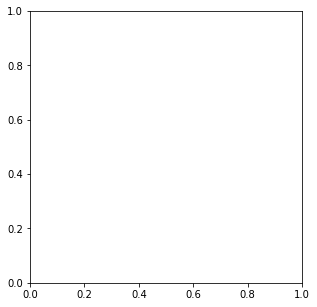

In [ ]:
imgpath = "./datasets/Test/6/"
savepath = "./datasets/segment006/"
size = 10

box=[]
for i in range(r['rois'].shape[0]):
    box.append([r['rois'][i][0]*10, r['rois'][i][1]*10, (r['rois'][i][2]+1)*10-1, (r['rois'][i][3]+1)*10-1])

plt.figure(figsize=(5,5))

for name in os.listdir(imgpath):
    image_path = os.path.join(imgpath,name)
    ll=len(name)
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for i in tqdm(range(len(box))):
        pic = img[box[i][0]:box[i][2], box[i][1]:box[i][3]]
        cv2.imwrite(savepath + name[0:ll-4] + "_"+str(i)+'.tif', pic)
        plt.imshow(pic)
        plt.show()

./datasets/1/1_555_STED_decon_gamma10.tif


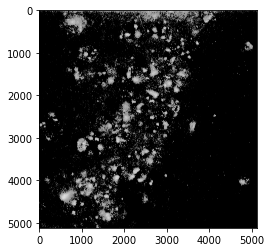

./datasets/1/1_488_STED_decon_gamma10.tif


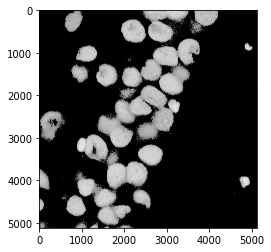

./datasets/1/1_488_STED_gamma10.tif


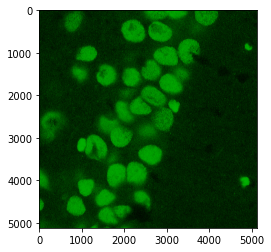

./datasets/1/1_555_STED_gamma10.tif


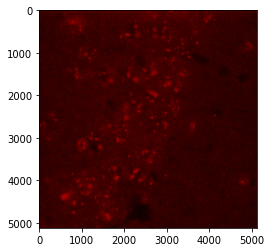

./datasets/1/1_555_conf_gamma10.tif


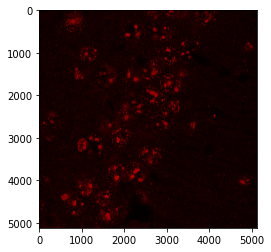

./datasets/1/1_488_conf_gamma10.tif


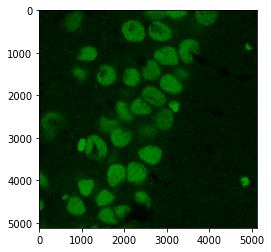

In [ ]:
for name in os.listdir(imgpath):
    image_path = os.path.join(imgpath,name)
    print(image_path)
    img = cv2.imread(image_path)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()